### Installation
1. Run the first 2 cells
2. Restart runtime
3. Run the rest of the jupyter notebooks (do not run the first 2 cells again)

In [1]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

from roboflow import Roboflow
from PIL import Image
import urllib3
urllib3.disable_warnings()

In [2]:
im = Image.open('mb2_1.png')

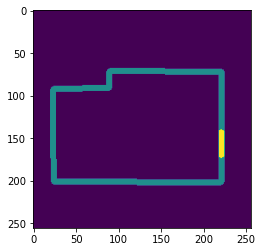

In [13]:
import matplotlib.pyplot as plt
plt.imshow(pix[:,:,0])

In [8]:
import numpy as np
pix = np.array(im)


(256, 256, 4)

In [2]:
import numpy as np
class point():
    def __init__(self, x, y):
        self.x = x
        self.y = y
def get_degree_three_points(p, p1, p2):
    v1 = np.array([p1.x - p.x, p1.y - p.y])
    v2 = np.array([p2.x - p.x, p2.y - p.y])
    unit_v1 = v1 / np.linalg.norm(v1)
    unit_v2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_v1, unit_v2)
    angle = np.math.atan2(np.linalg.det([unit_v1, unit_v2]), dot_product)
    degree = np.round(np.degrees(angle), 2)
    if degree > 90:
        degree = 180 - degree
    return abs(degree)

In [3]:
import math
def distance(p1, p2):
    return math.sqrt((p1.x-p2.x)**2 + (p1.y-p2.y)**2)

In [4]:
def refine_boundary(point_boundary):
    for i in range(len(point_boundary)-1):
        p0 = point(point_boundary[i][0],point_boundary[i][1])
        p1 = point(point_boundary[i + 1][0],point_boundary[i + 1][1])
        p = point(point_boundary[i][0],point_boundary[i][0] + 100)
        angle = get_degree_three_points(p0, p1, p)
        if (angle < 30 and angle != 0 and angle != 90) or math.abs(p0.x - p1.x) < 15:
            if point_boundary[i + 1][0] > point_boundary[i][0]:
                point_boundary[i + 1][0] = point_boundary[i][0]
            else:
                point_boundary[i ][0] = point_boundary[i + 1][0]
        if (angle > 60 and angle != 90 and angle != 0) or math.abs(p0.y - p1.y) < 15 :
            if point_boundary[i + 1][1] > point_boundary[i][1]:
                point_boundary[i + 1][1] = point_boundary[i][1]
            else:
                point_boundary[i ][1] = point_boundary[i + 1][1]
    return point_boundary
    

### Main Script

In [5]:
import tensorflow as tf
import sys
root = 'D:\\House3D\\Input_processing'
sys.path.append(root + '\\TF2DeepFloorplan')
sys.path.append(root + '\\TF2DeepFloorplan\\dfp')
from dfp.net import *
from dfp.data import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from argparse import Namespace
import os
import gc
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
sys.path.append(root + '\\TF2DeepFloorplan\\dfp\\utils')
from dfp.utils.rgb_ind_convertor import *
from dfp.utils.util import *
from dfp.utils.legend import *
from dfp.deploy import *
print(tf.test.is_gpu_available())
import cv2 as cv

<module 'dfp.utils._paths' from 'D:\\House3D\\Input_processing\\TF2DeepFloorplan\\dfp\\utils\\_paths.py'>
<module 'dfp._paths' from 'D:\\House3D\\Input_processing\\TF2DeepFloorplan\\dfp\\_paths.py'>
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [6]:
def door_detection(img_path = './30939153.jpg'):
    doors = []
    try:
        img = cv2.imread(img_path)
        #detection
        rf = Roboflow(api_key="7W0fIqzuiJGplpXG0C5L")

        workspace = rf.workspace("kuanghiu")

        project = workspace.project("door-yvyzd")

        version = project.version(1)

        model = version.model

        prediction = model.predict(img_path)

        json_file = prediction.json()
        #save results
        for it in json_file['predictions']:
            door = np.zeros((img.shape[0],img.shape[1]))
            door[int(it['y'] - it['height']/2) : int(it['y']+it['height']/2), int(it['x']- it['width']/2) : int(it['x'] + it['width']/2)] = 255
            doors.append(door)
        print('Detect door sussecful. Have {} doors in plan'.format(len(doors)))
    except:
        print('Something wrong. We dont find any door in plan')
    return doors

In [7]:
def resize_to_square(im, color = [0]):
    
    img_size = max(im.shape)
    old_size = im.shape
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])    
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    #color = [0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv.BORDER_CONSTANT,value=color)
    return new_im #cv.resize(new_im,(256,256), interpolation = cv.INTER_NEAREST)

In [8]:
from tools import *

def mask2labelme(mask):

    annotation = Annotation.from_mask(mask//255, image = None)
    
    polygons, hierarchy = annotation.polygons
    #polygon = Polygons.from_mask(mask)
    list_polygon = [ps.reshape(-1, 2) for ps in polygons]
    thres = 3
    '''for p in list_polygon:
        if thres < len(p):
            thres = len(p)'''
    lis_poly = []
    for p in list_polygon:
        point = []
        if len(p) >=  thres:
            lis_points = p.reshape(-1, 2)
            point.append([int(lis_points[0][0]), int(lis_points[0][1])])
            for i in range(len(lis_points)):
                if (abs(lis_points[i][0] - point[-1][0]) >1) or (abs(lis_points[i][1] - point[-1][1]) >1):
                    point.append([int(lis_points[i][0]), int(lis_points[i][1])])
        lis_poly.append(point)
    return lis_poly

In [9]:
def deepfloorplan(img_path):
    args = Namespace(image = img_path ,
            weight=root + '\\log\\store\\G',loadmethod='log',
            postprocess=True,colorize=True,
            save=None)
    result = main(args)
    img = result.astype(np.uint8)
    img = resize_to_square(img,color = [0])
    numpydata = np.asarray(img)
    return numpydata

In [10]:
def preprocces_data(img_path):
    
    numpydata = deepfloorplan(img_path)
    doors = door_detection(img_path)
    #Detection raw inside map
    inside_down = np.array([10,100,10])
    inside_up = np.array([255,255,255])
    mask_inside = cv2.inRange(numpydata, inside_down, inside_up)
     #Detection raw opening map
    opening_down = np.array([255-10, 60-10,128-10])
    opening_up = np.array([255, 60+10,128+10])
    mask_opening = cv2.inRange(numpydata, opening_down, opening_up)
    
    #Refine inside map 
    h_size = mask_inside.shape[1]
    w_size = mask_inside.shape[0]
    for r in range(0,h_size):
        if max(mask_inside[r]) >0:
            start = min(np.argwhere(mask_inside[r] == 255))[0]
            end  = max(np.argwhere(mask_inside[r] == 255))[0]
            mask_inside[r][start:end] = 255

    mask_inside_transpose = mask_inside.transpose()

    for r in range(0,w_size):
        if max(mask_inside_transpose[r]) >0:
            start = min(np.argwhere(mask_inside_transpose[r] == 255))[0]
            end  = max(np.argwhere(mask_inside_transpose[r] == 255))[0]
            mask_inside_transpose[r][start:end] = 255
    mask_inside = mask_inside_transpose.transpose() 
    
    #save boundary to points list
    _boundary = mask2labelme(mask_inside)
    #print(point_boundary)
    point_boundary = np.array(_boundary, np.int32)
    '''for i in range(len(_boundary[0])-1):
        p0 = point(_boundary[0][i][0],_boundary[0][i][1])
        p1 = point(_boundary[0][i + 1][0],_boundary[0][i + 1][1])
        d = distance(p0, p1)
        if d < 5:
            _boundary[0][i + 1][0] = _boundary[0][i][0]
            _boundary[0][i + 1][1] = _boundary[0][i][1]
    indexes = np.unique(_boundary[0], return_index=True, axis = 0)[1]
    point_boundary = refine_boundary(np.array([_boundary[0][index] for index in sorted(indexes)]))'''

    #Detection main door
    door = resize_to_square(sum(doors),color = [0])
    #save boundary to points list
    point_door = mask2labelme(door)
    point_door = np.array(point_door, np.int32)
    
    boundary = resize_to_square(cv.imread(img_path),color = [255, 255, 255])*0
    main_door  = resize_to_square(cv.imread(img_path),color = [255, 255, 255])*0
    
    cv2.polylines(boundary, [point_boundary], True, (255,0,0), thickness=5)
    cv2.polylines(main_door, point_door, True, (255,0,0), thickness=25)
    for i in range(h_size):
        for j in range(w_size):
            if main_door[:,:,0][i, j] == 255 and boundary[:,:,0][i, j] != 0:
                main_door[:,:,0][i, j] = 255
            else:
                main_door[:,:,0][i, j] = 0
    
    #save boundary to points list
    point_maindoor = mask2labelme(main_door[:,:,0])
    #point_maindoor = np.array(point_maindoor, np.int32)
              
    return point_boundary, point_maindoor



In [11]:
def resize_img(img_path):
    
    point_boundary, point_maindoor = preprocces_data(img_path)
    ratio = 256 / max(cv.imread(img_path).shape[0], cv.imread(img_path).shape[1])

    point_boundary = (point_boundary*ratio).astype('int32')
    #point_maindoor = (point_maindoor*ratio)

    wall  = cv.resize(cv.imread(img_path), (256, 256))*0
    inside  = cv.resize(cv.imread(img_path), (256, 256))*0

    cv2.polylines(wall, [point_boundary], True, (127,127,127), thickness=5) # boudary
    cv2.fillPoly(inside,[point_boundary],(255,255,255)) #inside
    i = 0
    for p in point_maindoor:
        i+=1
        door  = cv.resize(cv.imread(img_path), (256, 256))*0
        p = (np.array(p, np.int32)*ratio).astype('int32')
        cv2.polylines(door, [p], True, (128,128,128), thickness=5)



        #channel 0
        c0 = wall[:,:,0] + door[:,:,0]
        c0 = np.where(c0 != 128, c0, 0)
        #channel 1, 2
        c1 = np.zeros(c0.shape)
        c2 = np.zeros(c0.shape)
        #channel 3
        c3 = inside[:,:,0]

        img = np.stack([c0,c1,c2,c3], axis=-1).astype(np.uint8)
        output = Image.fromarray(img)

        output.save(img_path.split('.')[0] + f"_{i}.png")
        print(f'solved file: {img_path}')

In [12]:
resize_img('1.jpg')

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 1048576 values, but the requested shape requires a multiple of 786432 [Op:Reshape]

In [ ]:
import PIL.Image
rgba_image = PIL.Image.open('./Capture.png')
rgb_image = rgba_image.convert('RGB')
rgb_image.save('output.jpg')

In [ ]:
rgba_image.mode

In [ ]:
for img_path in os.listdir('C:/Users/kuanghiu/Deepfloorplan/test/input/'):
    try:
        resize_img('C:/Users/kuanghiu/Deepfloorplan/test/input/' + img_path)
    except:
        print(f'error in file: {img_path}')
    

In [ ]:
resize_img('C:/Users/kuanghiu/Deepfloorplan/test/input/mb3.jpg')